In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tike.ptycho
import importlib

In [2]:
for module in [np, tike]:
    print("{} is version {}".format(module.__name__, module.__version__))

numpy is version 1.12.1
tike is version 0.3.2.dev42+gba42807.d20181015


In [3]:
def plot_complex(img):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.abs(img))
    plt.subplot(1,2,2)
    plt.imshow(np.angle(img))
    plt.show()
    print(np.min(img), np.max(img))

# Create test data

Make a test data for pytchography reconstruction at one projection angle.

### Define the object

Normalize input uint8 images to the `[0, 1]` and `[0, pi]` ranges.

In [4]:
amplitude = plt.imread("./Cryptomeria_japonica-0128.tif") / 255
phase = plt.imread("./Erdhummel_Bombus_terrestris-0128.tif") / 255 * np.pi
np.min(phase), np.max(phase)

(0.036959913571644624, 3.1292726823992449)

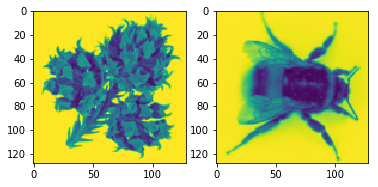

(-0.999924110115+0.0123196595352j) (0.995146916407+0.0984002782796j)


(1, 128, 128)

In [5]:
original = amplitude * np.exp(1j * phase)
original = np.tile(original, (1, 1, 1))
plot_complex(original[0])
original.shape

### Define the probe

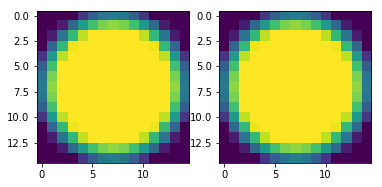

0j (0.980067+0.198669j)


In [6]:
pw = 15 # probe width
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
probe = weights * np.exp(1j * weights * 0.2)
plot_complex(probe)

### Define the trajectory

In [7]:
theta, h, v = np.meshgrid(0,
                          np.arange(0, amplitude.shape[0]-pw, 6),
                          np.arange(0, amplitude.shape[0]-pw, 6),
                          )
theta = theta.flatten().astype(int)
h = h.flatten().astype(int)
v = v.flatten().astype(int)
v

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108,   0,   6,  12,  18,  24,  30,  36,
        42,  48,  54,  60,  66,  72,  78,  84,  90,  96, 102, 108,   0,
         6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,  78,
        84,  90,  96, 102, 108,   0,   6,  12,  18,  24,  30,  36,  42,
        48,  54,  60,  66,  72,  78,  84,  90,  96, 102, 108,   0,   6,
        12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,  78,  84,
        90,  96, 102, 108,   0,   6,  12,  18,  24,  30,  36,  42,  48,
        54,  60,  66,  72,  78,  84,  90,  96, 102, 108,   0,   6,  12,
        18,  24,  30,  36,  42,  48,  54,  60,  66,  72,  78,  84,  90,
        96, 102, 108,   0,   6,  12,  18,  24,  30,  36,  42,  48,  54,
        60,  66,  72,  78,  84,  90,  96, 102, 108,   0,   6,  12,  18,
        24,  30,  36,  42,  48,  54,  60,  66,  72,  78,  84,  90,  96,
       102, 108,   0,   6,  12,  18,  24,  30,  36,  42,  48,  5

## Simulate data acquisition

In [8]:
# Then what we see at the detector is the wave propagation
# of the near field wavefront
data = tike.ptycho.simulate(data_shape=np.ones(2, dtype=int)*pw*3,
                            probe=probe, theta=theta, h=h, v=v,
                            psi=original)
data.shape

(361, 45, 45)

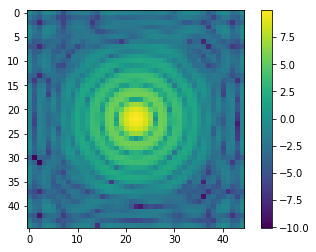

(7.0291847503363787e-07, 21374.175693533092)

In [9]:
plt.imshow(np.fft.fftshift(np.log(data[10])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

# Reconstruct

Now we need to try and reconstruct psi.

In [10]:
from tike.ptycho import grad
# Start with a guess of all zeros for psi
init = np.ones(original.shape, dtype=complex)

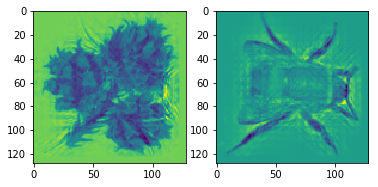

(0.164049998675-0.0630472924072j) (1.2244352795-0.0220899224915j)


In [11]:
new_psi = grad(data=data, probe=probe, theta=theta, h=h, v=v, psi=init,
               niter=10, rho=0.5, gamma=0.25)
plot_complex(new_psi[0])